# Master pipeline notebook


### This notebook follows the ML pipeline process of gathering data, performing analysis, modelling and evaluation


The process involves: 
1. Data gathering and pre-processing
2. Data analysis
3. Feature engineering 
4. Data transformation
5. LSTM Modelling 
6. Evaluation


_Note: Run the notebook from start to end._


In [1]:
import numpy as np
import pandas as pd
from data import gatherData
import plotly.graph_objects as go
from pre_process_data import processData
from feature import engineerFeaturesForTraining, splitData
from transform import transformData
from utils import load_config_file
from train import train
import plotly.figure_factory as ff
import torch
from LSTM_model import LSTM
from inference import makeInference
from evaluation import evaluateModellingResults
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
config = load_config_file("config.yml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data gathering and pre-processing

- Gather the data 
- Pre process it:
    - Merge columns from races_df and results_df
    - Add columns from pit_stop_df
    - Work on the outliers in the data
    - remove race_ids with less that 8 data points


In [3]:
gather_data_obj = gatherData(config=config)

In [4]:
(
    lap_times_df,
    pit_stops_df,
    qualifying_df,
    races_df,
    results_df,
    sprint_results_df,
    status_df,
) = gather_data_obj.load_data()

In [5]:
pre_process_obj = processData(config=config)

master_lap_times_df = pre_process_obj.create_initial_dataset(
    lap_times_df=lap_times_df, races_df=races_df, results_df=results_df
)
master_lap_times_df

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,1,1
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,1,1
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,1,1
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,1,1
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
551737,1110,817,40,17,114361,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551738,1110,817,41,17,113367,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551739,1110,817,42,16,115247,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551740,1110,817,43,16,112115,2023,12,13,Belgian Grand Prix,2023-07-30,3,1


In [6]:
# check for nans in the data
master_lap_times_df.isna().any()

raceId          False
driverId        False
lap             False
position        False
milliseconds    False
year            False
round           False
circuitId       False
name            False
date            False
number          False
statusId        False
dtype: bool

In [7]:
driver_id = 20
race_id = 841

lap_times_selected_driver_race = master_lap_times_df[
    (master_lap_times_df["raceId"] == race_id)
    & (master_lap_times_df["driverId"] == driver_id)
]

In [8]:
## Lap times and pit stops

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=lap_times_selected_driver_race["lap"],
        y=lap_times_selected_driver_race["milliseconds"],
        mode="lines+markers",
        name="Lap times in milliseconds",
    )
)

fig.update_layout(
    title="Laptimes by each lap", xaxis_title="Lap number", yaxis_title="Total lap time"
)

- Two outliers in the data 
- this is mainly the pit stops that happen in between the race

In [9]:
master_laptimes_pitstop_df = pre_process_obj.add_pitstop_data(
    master_laptime_data=master_lap_times_df, pit_stop_data=pit_stops_df
)
master_laptimes_pitstop_df

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId,pitStopMilliseconds,isPitStop
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551737,1110,817,40,17,114361,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551738,1110,817,41,17,113367,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551739,1110,817,42,16,115247,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551740,1110,817,43,16,112115,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False


In [10]:
driver_id = 20
lap_times_selected_driver = master_laptimes_pitstop_df[
    (master_laptimes_pitstop_df["driverId"] == driver_id)
]

In [11]:
fig = go.Figure()

# Add a box trace
fig.add_trace(
    go.Box(y=lap_times_selected_driver["milliseconds"], name="Lap times for Aus GP")
)

# Customize the layout
fig.update_layout(
    title="Box Plot with plotly.graph_objects",
    yaxis_title="Values",
)

# Show the figure
fig.show()

In [12]:
master_lap_time_data = pre_process_obj.work_on_outliers(
    master_lap_time_data=lap_times_selected_driver
)

## Data Analysis

In [13]:
histvalues = [master_lap_time_data["milliseconds"]]
names = ["lap times"]

fig = ff.create_distplot(
    histvalues,
    names,
    bin_size=10000,
    show_rug=False,
    curve_type="kde",
    histnorm="probability",
)

fig.show()

In [14]:
fig = go.Figure()

# Add a box trace
fig.add_trace(
    go.Box(y=master_lap_time_data["milliseconds"], name="Lap times for all GPs")
)

# Customize the layout
fig.update_layout(
    title="Box Plot for millisecond for all GPs",
    yaxis_title="Lap times (milliseconds)",
)

# Show the figure
fig.show()

In [15]:
fig = go.Figure()

circuit_id = 1

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

for race_id in list_race_id:

    lap_times_race = lap_times_selected_driver_circuit[
        lap_times_selected_driver_circuit["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

In [16]:
fig = go.Figure()

circuit_id = 12

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

for race_id in list_race_id:

    lap_times_race = lap_times_selected_driver_circuit[
        lap_times_selected_driver_circuit["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

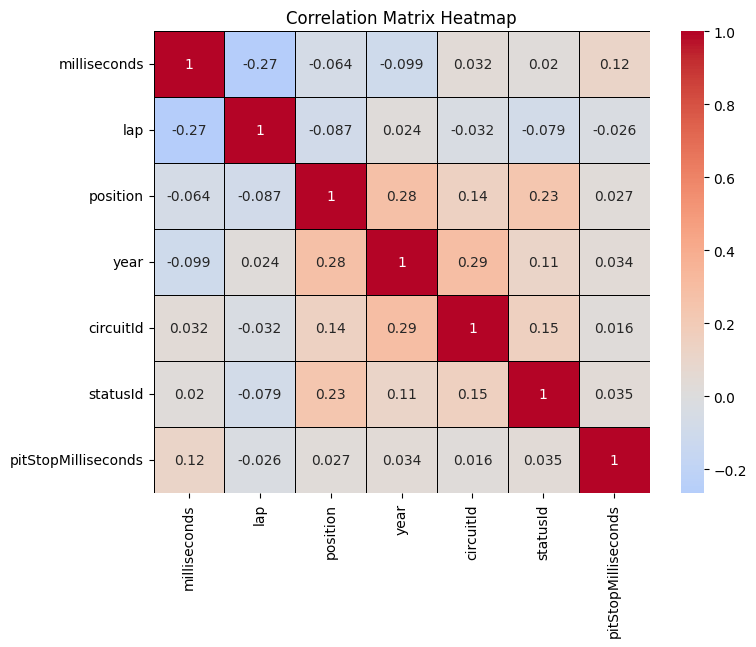

In [17]:
columns_for_corr = [
    "milliseconds",
    "lap",
    "position",
    "year",
    "circuitId",
    "statusId",
    "pitStopMilliseconds",
]

master_lap_time_data_corr_matrix = master_lap_time_data[columns_for_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    master_lap_time_data_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Feature Engineering

- Add columns that can help in modelling
    - add date feature columns
    - add lagged features: previous_lap_time, previous_lap_position, previous_lap_number
    - one hot encode the categorical features

In [18]:
engineer_data_obj = engineerFeaturesForTraining(config=config)


engineered_lap_times_df, encoder, encoder_columns = engineer_data_obj.engineer_data(
    lap_times_data=master_lap_time_data
)

In [19]:
engineered_lap_times_df

,raceId,lap,position,milliseconds,year,isPitStop,pitStopMilliseconds,milliseconds_1_prior,lap_number_1_prior,position_1_prior_lap,...,circuitId_68,circuitId_69,circuitId_70,circuitId_71,circuitId_73,circuitId_75,circuitId_76,circuitId_77,circuitId_78,circuitId_79
1,1,2,2,91173.0,2009,0,0.0,99647.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,2,89752.0,2009,0,0.0,91173.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,2,88999.0,2009,0,0.0,89752.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,2,88849.0,2009,0,0.0,88999.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,2,88424.0,2009,0,0.0,88849.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,1096,54,11,90931.0,2022,0,0.0,91056.0,53.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16395,1096,55,11,91304.0,2022,0,0.0,90931.0,54.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16396,1096,56,10,91485.0,2022,0,0.0,91304.0,55.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16397,1096,57,10,91227.0,2022,0,0.0,91485.0,56.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
fig = go.Figure()


for race_id in list_race_id:

    lap_times_race = engineered_lap_times_df[
        engineered_lap_times_df["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds_1_prior"],
            mode="lines+markers",
            name=f"race id: {race_id} 1 prior",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap and prior lap {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

In [21]:
engineered_lap_times_df.columns

Index(['raceId', 'lap', 'position', 'milliseconds', 'year', 'isPitStop',
       'pitStopMilliseconds', 'milliseconds_1_prior', 'lap_number_1_prior',
       'position_1_prior_lap', 'pitStopMilliseconds_1_prior',
       'isPitStop_1_prior', 'month', 'day', 'circuitId_1', 'circuitId_2',
       'circuitId_3', 'circuitId_4', 'circuitId_5', 'circuitId_6',
       'circuitId_7', 'circuitId_8', 'circuitId_9', 'circuitId_10',
       'circuitId_11', 'circuitId_12', 'circuitId_13', 'circuitId_14',
       'circuitId_15', 'circuitId_16', 'circuitId_17', 'circuitId_18',
       'circuitId_19', 'circuitId_20', 'circuitId_21', 'circuitId_22',
       'circuitId_24', 'circuitId_32', 'circuitId_34', 'circuitId_35',
       'circuitId_39', 'circuitId_68', 'circuitId_69', 'circuitId_70',
       'circuitId_71', 'circuitId_73', 'circuitId_75', 'circuitId_76',
       'circuitId_77', 'circuitId_78', 'circuitId_79'],
      dtype='object')

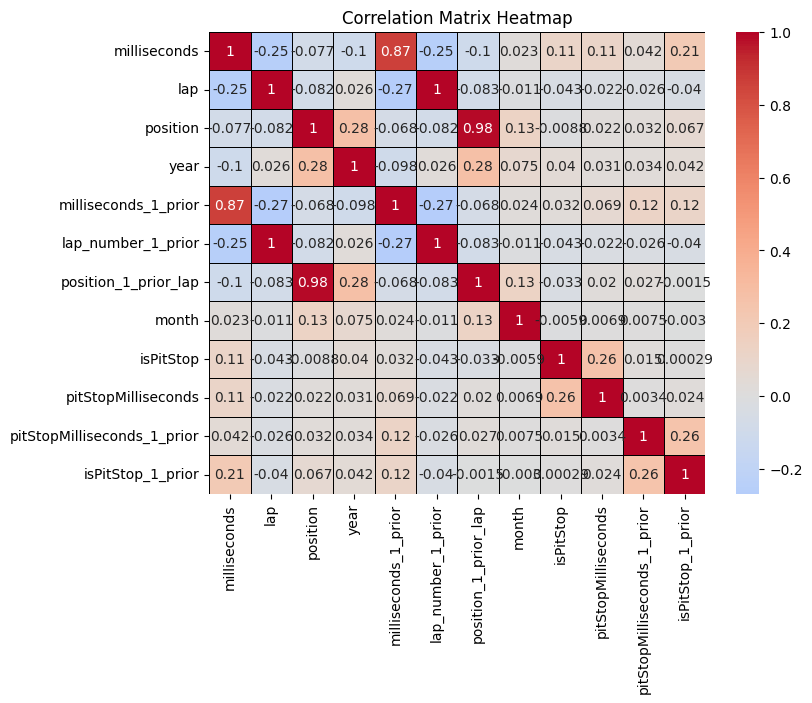

In [22]:
columns_for_corr = [
    "milliseconds",
    "lap",
    "position",
    "year",
    "milliseconds_1_prior",
    "lap_number_1_prior",
    "position_1_prior_lap",
    "month",
    "isPitStop",
    "pitStopMilliseconds",
    "pitStopMilliseconds_1_prior",
    "isPitStop_1_prior",
]

engineered_lap_times_df_corr_matrix = engineered_lap_times_df[columns_for_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    engineered_lap_times_df_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [23]:
engineered_lap_times_df[engineered_lap_times_df["raceId"]==841][['raceId', 'lap', 'position', 'milliseconds', 'year', 'isPitStop',
       'pitStopMilliseconds', 'milliseconds_1_prior', 'lap_number_1_prior',
       'position_1_prior_lap', 'pitStopMilliseconds_1_prior',
       'isPitStop_1_prior', 'month', 'day']]

,raceId,lap,position,milliseconds,year,isPitStop,pitStopMilliseconds,milliseconds_1_prior,lap_number_1_prior,position_1_prior_lap,pitStopMilliseconds_1_prior,isPitStop_1_prior,month,day
3118,841,2,1,93006.0,2011,0,0.0,98109.0,1.0,1.0,0.0,0.0,3,27
3119,841,3,1,92713.0,2011,0,0.0,93006.0,2.0,1.0,0.0,0.0,3,27
3120,841,4,1,92803.0,2011,0,0.0,92713.0,3.0,1.0,0.0,0.0,3,27
3121,841,5,1,92342.0,2011,0,0.0,92803.0,4.0,1.0,0.0,0.0,3,27
3122,841,6,1,92605.0,2011,0,0.0,92342.0,5.0,1.0,0.0,0.0,3,27
3123,841,7,1,92502.0,2011,0,0.0,92605.0,6.0,1.0,0.0,0.0,3,27
3124,841,8,1,92537.0,2011,0,0.0,92502.0,7.0,1.0,0.0,0.0,3,27
3125,841,9,1,93240.0,2011,0,0.0,92537.0,8.0,1.0,0.0,0.0,3,27
3126,841,10,1,92572.0,2011,0,0.0,93240.0,9.0,1.0,0.0,0.0,3,27
3127,841,11,1,92669.0,2011,0,0.0,92572.0,10.0,1.0,0.0,0.0,3,27


In [24]:
# drop columns to avoid data leak
engineered_lap_times_df = engineered_lap_times_df.drop(columns=config.get("DROP_COLUMNS_AVOID_LEAKAGE"))
engineered_lap_times_df

,raceId,lap,milliseconds,year,milliseconds_1_prior,lap_number_1_prior,position_1_prior_lap,pitStopMilliseconds_1_prior,isPitStop_1_prior,month,...,circuitId_68,circuitId_69,circuitId_70,circuitId_71,circuitId_73,circuitId_75,circuitId_76,circuitId_77,circuitId_78,circuitId_79
1,1,2,91173.0,2009,99647.0,1.0,2.0,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,89752.0,2009,91173.0,2.0,2.0,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,88999.0,2009,89752.0,3.0,2.0,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,88849.0,2009,88999.0,4.0,2.0,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,88424.0,2009,88849.0,5.0,2.0,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,1096,54,90931.0,2022,91056.0,53.0,11.0,0.0,0.0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16395,1096,55,91304.0,2022,90931.0,54.0,11.0,0.0,0.0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16396,1096,56,91485.0,2022,91304.0,55.0,11.0,0.0,0.0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16397,1096,57,91227.0,2022,91485.0,56.0,10.0,0.0,0.0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Spliting into train test

 - First a race_id is selected which will act as an unseen set, and the model will perform predictions on it

In [25]:
split_obj = splitData()

train_data, test_data = split_obj.train_test_split(
    data=engineered_lap_times_df, race_id=config.get("RACE_ID_TEST_SET")
)

# Transform data for LSTM model
- scaling 
    - Scale each numerical column using appropriate scaler
- sequencing
    - all scaled and categorical columns are combined 
    - the dataframe is then converted to a sequential tensor

In [26]:
data_transform_obj = transformData(
    n_steps_input=config.get("NUMBER_OF_HISTORICAL_LAP"),
    n_steps_output=config.get("N_STEP_OUTPUT"),
    config=config,
)

scaled_input_df_train, scaled_output_df_train = (
    data_transform_obj.create_scaled_input_output_data(data=train_data, train=True)
)

INFO:root:scaler_dict.pkl saved to ../artifacts/


In [27]:
x_sequential_train, y_sequential_train = data_transform_obj.create_sequence(
    scaled_input_df=scaled_input_df_train, scaled_output_df=scaled_output_df_train
)

In [28]:
x_train, x_val, y_train, y_val = split_obj.train_validation_split(
    x_sequential_ls=x_sequential_train, y_sequential_ls=y_sequential_train
)

In [29]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

x_train = torch.reshape(
    x_train,
    (
        x_train.shape[0],
        config.get("NUMBER_OF_HISTORICAL_LAP"),
        x_train.shape[2],
    ),
)

x_validation = torch.Tensor(x_val)
y_validation = torch.Tensor(y_val)

x_validation = torch.reshape(
    x_validation,
    (
        x_validation.shape[0],
        config.get("NUMBER_OF_HISTORICAL_LAP"),
        x_validation.shape[2],
    ),
)

## Model training
- Create data loader for the LSTM model
- define LSTM model architecture
- define training loop
- train and save the model 

In [30]:
train_obj = train(config=config)

train_data_loader, validation_data_loader = train_obj.create_data_loader(
    batch_size=config.get("BATCH_SIZE"),
    x_train=x_train,
    y_train=y_train,
    x_validation=x_validation,
    y_validation=y_validation,
)

In [31]:
x_train.shape[2]

47

In [32]:
lstm_model = LSTM(
    num_classes=config.get("N_STEP_OUTPUT"),
    input_size=x_train.shape[2],
    hidden_size_layer_1=config.get("HIDDEN_SIZE_1"),
    hidden_size_layer_2=config.get("HIDDEN_SIZE_2"),
    num_layers=config.get("NUM_LAYERS"),
    dense_layer_size=config.get("DENSE_LAYER"),
    dropout_rate=0.1,
)
lstm_model.to(device)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

validation_loss_ls, ls_train_loss = train_obj.train_validation_loop(
    n_epochs=50,
    lstm_model=lstm_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_data_loader,
    validation_loader=validation_data_loader,
    device=device,
)

Epoch num: 0
Average train loss accross batch: 0.3891372680610112
Validation loss: 0.38589754700660706
Epoch num: 1
Average train loss accross batch: 0.3615659710807506
Validation loss: 0.42710644006729126
Epoch num: 2
Average train loss accross batch: 0.3538279420669898
Validation loss: 0.3705081045627594
Epoch num: 3
Average train loss accross batch: 0.353150408523485
Validation loss: 0.37271004915237427
Epoch num: 4
Average train loss accross batch: 0.3487074098439859
Validation loss: 0.3696855902671814
Epoch num: 5
Average train loss accross batch: 0.34852743761412996
Validation loss: 0.3690558969974518
Epoch num: 6
Average train loss accross batch: 0.34345419503138774
Validation loss: 0.3635013699531555
Epoch num: 7
Average train loss accross batch: 0.3436933391276345
Validation loss: 0.3774324059486389
Epoch num: 8
Average train loss accross batch: 0.35031965963143225
Validation loss: 0.37319377064704895
Epoch num: 9
Average train loss accross batch: 0.35533852182776493
Validatio

KeyboardInterrupt: 

In [ ]:
fig = go.Figure()

loss_df = pd.DataFrame({"validation_loss": validation_loss_ls, "train_loss": ls_train_loss })


fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["validation_loss"],
        mode="lines+markers",
        name="Validation Loss",
    )
)

fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["train_loss"],
        mode="lines+markers",
        name="Train Loss",
    )
)

fig.update_layout(
    title="Validation loss while training",
    xaxis_title="Epochs",
    yaxis_title="Validation loss",
)
fig.show()

## Evaluation

- Check model performance in real life setting
- Compare with laptimes from the unseen race id selected earlier
- show the model performance throughout the race

In [ ]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=test_data, device=device
)

tensor([[0.6416, 0.6994, 0.7278, 0.7005, 0.6907],
        [0.6488, 0.7059, 0.7365, 0.7088, 0.6980],
        [0.6905, 0.7451, 0.7801, 0.7489, 0.7403],
        [0.6893, 0.7439, 0.7788, 0.7476, 0.7390],
        [0.6328, 0.6914, 0.7172, 0.6901, 0.6818],
        [0.6294, 0.6883, 0.7131, 0.6862, 0.6784],
        [0.6224, 0.6820, 0.7046, 0.6779, 0.6713],
        [0.6239, 0.6833, 0.7063, 0.6796, 0.6728],
        [0.6158, 0.6760, 0.6966, 0.6702, 0.6646],
        [0.5966, 0.6586, 0.6733, 0.6476, 0.6452],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.9525, 0.6997, 0.5363, 0.2779, 0.2196],
        [0.7294, 0.7815, 0.8211, 0.7866, 0.7798],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],
        [0.5880, 0.6508, 0.6629, 0.6375, 0.6365],


In [ ]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[106194.9335641861, 107428.16613224149, 108035.48136842251, 107451.35928061604, 107243.14505544305]
[106348.62379130721, 107567.73973104358, 108220.38795512915, 107630.13555896282, 107398.5984299779]
[107239.7459718287, 108403.45506769419, 109151.46336135268, 108484.63999179006, 108302.55367767811]
[107212.63980653882, 108378.03445097804, 109123.14232897758, 108458.6469246149, 108275.05570185184]
[106007.5349098146, 107258.28573402762, 107808.38645499945, 107231.26734447479, 107053.6270622611]
[105935.5588054359, 107193.03783071041, 107721.16408672929, 107146.73294913769, 106980.83680611849]
[105785.75106453896, 107057.23350015283, 107539.62223660946, 106970.78966450691, 106829.3346118629]
[105816.54762712121, 107085.15127298236, 107576.94346231222, 107006.95962873101, 106860.47973316908]
[105644.41050198674, 106929.10636630654, 107368.34251505136, 106804.79048040509, 106686.39500436187]
[105235.03464129567, 106557.99818274379, 106872.25058671832, 106323.99442833662, 106272.38865551353

In [ ]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)